# Own Exploration

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib as plt



In [2]:
# Read the data from the file
df = pd.read_csv('Data/train_values.csv')
df_labels = pd.read_csv('Data/train_labels.csv')
test_df = pd.read_csv('Data/test_values.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/train_values.csv'

In [ ]:
# Merge the dataframes
df_all = df.merge(df_labels, on='building_id')

In [ ]:
df_all.dtypes

In [ ]:
def binary_encode(df):
    """
    Binary encode the given dataframe.

    Args:
        df (DataFrame): The dataframe to be binary encoded.

    Returns:
        DataFrame: The binary encoded dataframe.
    """
    import category_encoders as ce
    cols = [
        'ground_floor_type', 'land_surface_condition', 'foundation_type', 'roof_type', 
        'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status', 'geo_level_1_id', 
        'geo_level_2_id', 'geo_level_3_id'
            ]
    encoder = ce.BinaryEncoder(cols=cols)
    binary_encoded = encoder.fit_transform(df)
    return binary_encoded

df_all = binary_encode(df_all)



In [ ]:
df_all.dtypes

building_id                      int64
geo_level_1_id_0                 int64
geo_level_1_id_1                 int64
geo_level_1_id_2                 int64
geo_level_1_id_3                 int64
                                 ...  
has_secondary_use_health_post    int64
has_secondary_use_gov_office     int64
has_secondary_use_use_police     int64
has_secondary_use_other          int64
damage_grade                     int64
Length: 82, dtype: object

<Axes: xlabel='damage_grade'>

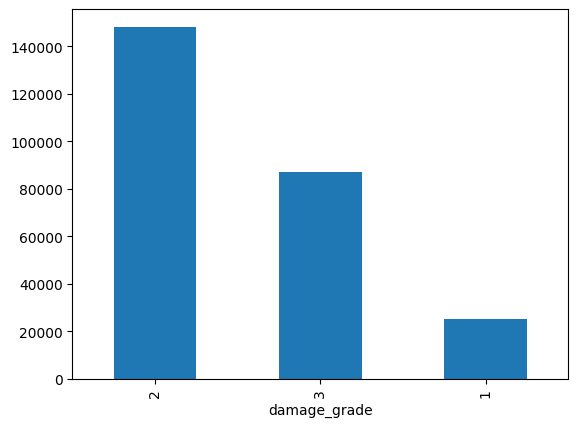

In [ ]:
#plot of the damage grade
df_all['damage_grade'].value_counts().plot(kind='bar')

In [ ]:
from imblearn.over_sampling import SMOTE

# Define the predictor variables (X) and the target variable (y)
X = df_all.drop(columns=['damage_grade'])  # Exclude 'damage_grade'
y = df_all['damage_grade']

# Apply SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled X and y back into one dataset
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)


<Axes: xlabel='damage_grade'>

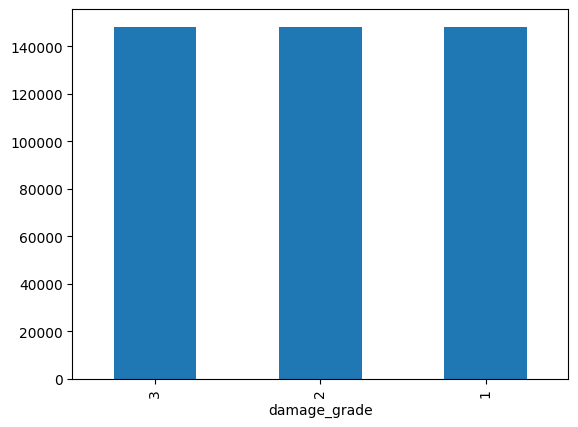

In [ ]:
#plot of damage_grade in resampled_df
resampled_df['damage_grade'].value_counts().plot(kind='bar')


In [ ]:
def XGBoost(df_all):
    """
    Create a XGBoost classifier and fit it to the train data.

    Args:
        training data set

    Returns:
        ?
    """

    import xgboost as xgb
    from sklearn.metrics import accuracy_score, f1_score
    from sklearn.model_selection import train_test_split

    data=df_all

    # Define the predictor variables (X) and the target variable (y)
    X = data.drop(['building_id', 'damage_grade'], axis=1)
    y = data['damage_grade']

    #change categories of y to start from 0 bc softmax likes it that way
    y = y - 1

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the hyperparameters
    hyperparameters = {
        'n_estimators': 535,
        'max_depth': 10,
        'learning_rate': 0.051232294238614126,
        'subsample': 0.6796645277288101,
        'colsample_bytree': 0.7886065868653529,
        'objective': 'multi:softmax',  # Specify multi-class classification objective
        'num_class': 3  # Number of classes in your multi-class problem
    }

    # Create an XGBoost classifier with the specified hyperparameters
    classifier = xgb.XGBClassifier(**hyperparameters)

    # Fit the classifier to the training data (X_train, y_train)
    classifier.fit(X_train, y_train)

    # Predict on the test data (X_test)
    y_pred = classifier.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate the micro F1 score
    micro_f1 = f1_score(y_test, y_pred, average='micro')

    return micro_f1, accuracy

In [ ]:
# micro f1 and accuracy of XGBoost on resampled data

XGBoost(df_all)

(0.7473379252124863, 0.7473379252124863)

In [ ]:
# micro f1 and accuracy of XGBoost on resampled data

XGBoost(resampled_df)

(0.823530734295607, 0.8235307342956069)